# Load Data
We will load `train.csv` and restructure it to work more efficiently with our data generator

In [1]:
import pandas as pd, numpy as np, os
from PIL import Image 
import cv2, keras, gc
import keras.backend as K
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt, time
from sklearn.metrics import roc_auc_score, accuracy_score

Using TensorFlow backend.


In [2]:
TRAIN_MODELS = False

sub = pd.read_csv('../input/understanding_cloud_organization/sample_submission.csv')
sub['Image'] = sub['Image_Label'].map(lambda x: x.split('.')[0])

train = pd.read_csv('../input/understanding_cloud_organization/train.csv')
train['Image'] = train['Image_Label'].map(lambda x: x.split('.')[0])
train['Label'] = train['Image_Label'].map(lambda x: x.split('_')[1])
train2 = pd.DataFrame({'Image':train['Image'][::4]})
train2['e1'] = train['EncodedPixels'][::4].values
train2['e2'] = train['EncodedPixels'][1::4].values
train2['e3'] = train['EncodedPixels'][2::4].values
train2['e4'] = train['EncodedPixels'][3::4].values
train2.set_index('Image',inplace=True,drop=True)
train2.fillna('',inplace=True); train2.head()
train2[['d1','d2','d3','d4']] = (train2[['e1','e2','e3','e4']]!='').astype('int8')
train2.head()

e1  \
Image                                                        
0011165  264918 937 266318 937 267718 937 269118 937 27...   
002be4f  233813 878 235213 878 236613 878 238010 881 23...   
0031ae9  3510 690 4910 690 6310 690 7710 690 9110 690 1...   
0035239                                                      
003994e  2367966 18 2367985 2 2367993 8 2368002 62 2369...   

                                                        e2  \
Image                                                        
0011165  1355565 1002 1356965 1002 1358365 1002 1359765...   
002be4f  1339279 519 1340679 519 1342079 519 1343479 51...   
0031ae9  2047 703 3447 703 4847 703 6247 703 7647 703 9...   
0035239  100812 462 102212 462 103612 462 105012 462 10...   
003994e                                                      

                                                        e3  \
Image                                                        
0011165                                                      
002be4f                                                      
0031ae9                                                      
0035239  65400 380 66800 380 68200 380 69600 380 71000 ...   
003994e  353317 416 354717 416 356117 416 357517 416 35...   

                                                        e4  d1  d2  d3  d4  
Image                                                                       
0011165                                                      1   1   0   0  
002be4f  67495 350 68895 350 70295 350 71695 350 73095 ...   1   1   0   1  
0031ae9  658170 388 659570 388 660970 388 662370 388 66...   1   1   0   1  
0035239                                                      0   1   1   0  
003994e  28011 489 29411 489 30811 489 32211 489 33611 ...   1   0   1   1

# Data Generator
This data generator outputs resized full images when `mode = train` with class labels or with bounding boxes when `mode = train_bb`. Additionally there are parameters to apply data augmentation flips and shake. Also images can be normalized with parameters `scale` and `sub` such that `output = img * scale - sub`.

In [3]:
class DataGenerator(keras.utils.Sequence):
    # USES GLOBAL VARIABLE TRAIN2 COLUMNS E1, E2, E3, E4
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=8, shuffle=False, width=525, height=350, scale=1/128., sub=1., mode='train',
                 path='../input/understanding_cloud_organization/train_images/', ext='.jpg', shake=0, flips=False, dft=1):
        'Initialization'
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.path = path
        self.scale = scale
        self.sub = sub
        self.path = path
        self.ext = ext
        self.width = width
        self.height = height
        self.mode = mode
        self.shake = shake
        self.flips = flips
        self.dft = dft
        self.on_epoch_end()
        if (mode=='train_bb')&((width!=525)|(height!=350)|(shake>0)):
            print('ERROR: wrong size or shake for train_bb')
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int(np.floor( len(self.list_IDs) / self.batch_size))
        if len(self.list_IDs)>ct*self.batch_size: ct += 1
        return int(ct)

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y, bb = self.__data_generation(indexes)
        if (self.mode=='train')|(self.mode=='validate'): return X, y
        elif self.mode=='train_bb': return X, bb
        else: return X

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(int( len(self.list_IDs) ))
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        # Initialization
        lnn = len(indexes)
        X = np.empty((lnn,self.height-self.shake,self.width-self.shake,3),dtype=np.float32)
        y = np.zeros((lnn,4),dtype=np.int8)
        bb = np.zeros((lnn,4),dtype=np.int16)
        
        # Generate data
        for k in range(lnn):
            img = cv2.imread(self.path + self.list_IDs[indexes[k]] + self.ext)
            img = cv2.resize(img,(self.width,self.height),interpolation = cv2.INTER_AREA)
            # AUGMENTATION FLIPS
            hflip = False; vflip = False
            if (self.flips):
                if np.random.uniform(0,1)>0.5: hflip=True
                if np.random.uniform(0,1)>0.5: vflip=True
            if vflip: img = cv2.flip(img,0) # vertical
            if hflip: img = cv2.flip(img,1) # horizontal
            # AUGMENTATION SHAKE
            a = 0; b = 0
            if self.shake>0:
                a = np.random.randint(0,self.shake+1)
                b = np.random.randint(0,self.shake+1)
                if (self.mode=='predict')|(self.mode=='validate'):
                    a = self.shake//2; b = self.shake//2
            img = img[b:(self.height-self.shake)+b,a:(self.width-self.shake)+a]
            # NORMALIZE IMAGES
            X[k,] = img*self.scale - self.sub      
            # LABELS
            if (self.mode=='train')|(self.mode=='validate'):
                y[k,] = train2.loc[self.list_IDs[indexes[k]],['d1','d2','d3','d4']].values
            # BOUNDING BOXES
            if (self.mode=='train_bb'):
                bb[k,] = train2.loc[self.list_IDs[indexes[k]],'b'+str(self.dft)]
                bb[k,] = bb[k,]//4
                if vflip: bb[k,0] = (350-bb[k,0])-bb[k,2]
                if hflip: bb[k,1] = (525-bb[k,1])-bb[k,3]
            
        return X, y, bb

# Build Classifier Model
Will will use pretrained Xception model with 4 `sigmoid` outputs and `binary_crossentropy` loss to classify our cloud images.

In [4]:
from keras import applications
#! pip install keras_efficientnets
#from keras_efficientnets import EfficientNetB4

def build_model():
    base_model = applications.Xception(weights='imagenet', input_shape=(350-32, 525-32, 3), include_top=False)
    #base_model = EfficientNetB4(input_shape=(350-32, 525-32, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    #x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation="relu")(x)
    #x = layers.Dropout(0.4)(x)

    pred = layers.Dense(4, activation="sigmoid")(x)
    model = Model(inputs = base_model.input, outputs = pred)
    model.compile(loss='binary_crossentropy', optimizer = "adam", metrics=['accuracy'])
    
    return model

# Train Classifier Model
We will training our Xception model on 3 folds using resized full images and data augmentation. Augmentation includes horizontal flip, vertical flip, and shake (random crops that are slighly smaller than full size).

In [5]:
if TRAIN_MODELS:
    oof = np.zeros((train2.shape[0],4))
    preds = np.zeros((sub.Image.values[::4].shape[0],4))

    skf = KFold(n_splits=3, shuffle=True, random_state=42)
    for k, (idxT, idxV) in enumerate( skf.split(train2) ):

        model = build_model()
        train_gen = DataGenerator(train2.index[idxT],shake=32,flips=True,shuffle=True)
        val_gen = DataGenerator(train2.index[idxV],shake=32,mode='validate')
    
        print()
        print('#'*10,'FOLD',k,'#'*10)
        print('#'*10,'TRAIN','#'*10)
        h = model.fit_generator(train_gen, epochs = 3, verbose=1, validation_data = val_gen)
   
        print('#'*10,'PREDICT','#'*10)
        test_gen = DataGenerator(sub.Image.values[::4], mode='predict', batch_size=8,
                path='../input/understanding_cloud_organization/test_images/', shake=32)
        preds += model.predict_generator(test_gen, verbose=1)
        oof[idxV,] = model.predict_generator(val_gen, verbose=1)
        
        # FREE GPU MEMORY (BEING EXTRA CAREFUL HERE)
        del train_gen, val_gen, test_gen, model, h, idxT, idxV
        K.clear_session(); x=gc.collect()
            
    preds /= skf.n_splits
else:
    oof = np.load('../input/cloudpred1/oof.npy')
    preds = np.load('../input/cloudpred1/preds.npy')
    print('Saving time by loading classification OOF and Preds')

Saving time by loading classification OOF and Preds


# Evaluate Classifier Model using OOF
Below shows the AUC and ACC for each type of prediction

In [6]:
type = ['Fish','Flower','Gravel','Sugar']
for k in range(1,5): train2['o'+str(k)] = 0
train2[['o1','o2','o3','o4']] = oof

for k in range(1,5):
    print(type[k-1],': ',end='')
    auc = np.round( roc_auc_score(train2['d'+str(k)].values,train2['o'+str(k)].values  ),3 )
    acc = np.round( accuracy_score(train2['d'+str(k)].values,(train2['o'+str(k)].values>0.5).astype(int) ),3 )
    print('AUC =',auc,end='')
    print(', ACC =',acc) 
print('OVERALL: ',end='')
auc = np.round( roc_auc_score(train2[['d1','d2','d3','d4']].values.reshape((-1)),train2[['o1','o2','o3','o4']].values.reshape((-1)) ),3 )
acc = np.round( accuracy_score(train2[['d1','d2','d3','d4']].values.reshape((-1)),(train2[['o1','o2','o3','o4']].values>0.5).astype(int).reshape((-1)) ),3 )
print('AUC =',auc, end='')
print(', ACC =',acc) 

Fish : AUC = 0.754, ACC = 0.683
Flower : AUC = 0.892, ACC = 0.818
Gravel : AUC = 0.763, ACC = 0.688
Sugar : AUC = 0.797, ACC = 0.748
OVERALL: AUC = 0.818, ACC = 0.734


# Create Bounding Boxes
We will naively create bounding boxes by finding the smallest bounding box that includes the entire given mask. Afterwards we compute the dice score of our created bounding box compared to original mask. Later we use this dice score to exclude any bounding box with dice less than 0.8 from our training.

In [7]:
def rle2mask(mask_rle, shape=(2100,1400), shrink=1):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T[::shrink,::shrink]

def rle2bb(rle):
    if rle=='': return (0,0,0,0)
    mask = rle2mask(rle)
    z = np.argwhere(mask==1)
    mn_x = np.min( z[:,0] )
    mx_x = np.max( z[:,0] )
    mn_y = np.min( z[:,1] )
    mx_y = np.max( z[:,1] )
    return (mn_x,mn_y,mx_x-mn_x,mx_y-mn_y)

def bb2dice(rle,bb,shape=(2100,1400)):
    mask1 = rle2mask(rle,shape)
    mask2 = np.zeros((shape[1],shape[0]))
    mask2[bb[0]:bb[0]+bb[2],bb[1]:bb[1]+bb[3]]=1
    union = np.sum(mask1) + np.sum(mask2)
    if union==0: return 1
    intersection = np.sum(mask1*mask2)
    return 2.*intersection/union

In [8]:
if TRAIN_MODELS:
    for k in range(1,5):
        print('Computing bb',k,'...',end='')
        train2['b'+str(k)] = train2['e'+str(k)].map(rle2bb)
        print('Computing dice_bb',k,'...',end='')
        train2['s'+str(k)] = train2.apply(lambda x: bb2dice(x['e'+str(k)],x['b'+str(k)]),axis=1)
    print('Done')
    train2.head()
else:
    for k in range(1,5):
        train2['b'+str(k)] = np.load('../input/cloudpred1/bb'+str(k)+'.npy',allow_pickle=True)[:,0]
        train2['s'+str(k)] = np.load('../input/cloudpred1/bb'+str(k)+'.npy',allow_pickle=True)[:,1]
    print('Saving time by loading computed bounding boxes')

Saving time by loading computed bounding boxes


# Build Bounding Box Model
We will use pretrained Xception model with 4 linear outputs and `mean_squared_error` loss to model bounding boxes. Note that a bounding box is 4 numbers `(y, x, height, width)` where `(y,x)` is the coordinate of the top left corner.

In [9]:
from keras import applications
#! pip install keras_efficientnets
#from keras_efficientnets import EfficientNetB4

def build_model():
    base_model = applications.Xception(weights='imagenet', input_shape=(350, 525, 3), include_top=False)
    #base_model = EfficientNetB4(input_shape=(350-32, 525-32, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    #x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation="relu")(x)
    #x = layers.Dropout(0.4)(x)

    pred = layers.Dense(4, activation="linear")(x)
    model = Model(inputs = base_model.input, outputs = pred)
    model.compile(loss='mean_squared_error', optimizer = "adam")
    
    return model

# Train Bounding Box Model
We will train 4 separate models for each cloud type. We will only train with images that have a bounding box that has dice score of 0.8 or larger when compared with the original masks. Furthermore we will only use images that our classification model above predicted a probability more than 0.5 for that class.

In [10]:
type2 = ['FISH','FLOWER','GRAVEL','SUGAR']
if TRAIN_MODELS:
    oof_bb = np.zeros((train2.shape[0],4,4))
    preds_bb = np.zeros((sub.Image.values[::4].shape[0],4,4))

    skf = KFold(n_splits=3, shuffle=True, random_state=42)
    for k, (idxT, idxV) in enumerate( skf.split(train2) ):
        print(); print('#'*28)
        print('#'*10,'FOLD',k,'#'*10)
        print('#'*28)
        for j in [1,2,3,4]:
            model = build_model()
            one = train2[ (train2.index.isin(train2.index[idxT]))&(train2['d'+str(j)]==1)&(train2['s'+str(j)]>0.8)&(train2['o'+str(j)]>0.5) ]
            two = train2[ (train2.index.isin(train2.index[idxV]))&(train2['d'+str(j)]==1)&(train2['s'+str(j)]>0.8)&(train2['o'+str(j)]>0.5) ]
            train_gen = DataGenerator(one.index,mode='train_bb',shuffle=True,flips=True,dft=j)
            val_gen = DataGenerator(two.index,mode='train_bb',dft=j)
        
            print(); print('#'*10,'TRAIN CLOUD',type2[j-1],' (fold',str(k)+')','#'*10)
            print(' train on',len(one),', validate on',len(two))
            h = model.fit_generator(train_gen, epochs = 5, verbose=1, validation_data = val_gen)

    
            print('#'*10,'PREDICT OOF AND TEST','#'*10)
            test_gen = DataGenerator(sub.Image.values[::4], mode='predict', batch_size=8,
                    path='test_images/')
            val_gen2 = DataGenerator(train2.index[idxV],mode='predict')
            preds_bb[:,:,j-1] += model.predict_generator(test_gen, verbose=1)
            oof_bb[idxV,:,j-1] = model.predict_generator(val_gen2, verbose=1)
        
            # FREE GPU MEMORY
            del train_gen, val_gen, val_gen2, test_gen, model, h, annealer, one, two
            K.clear_session(); x=gc.collect()
            
    preds_bb /= skf.n_splits
else:
    oof_bb = np.load('../input/cloudpred1/oof_bb.npy')
    preds_bb = np.load('../input/cloudpred1/preds_bb.npy')
    print('Saving time by loading Bounding Box OOF and Preds')

Saving time by loading Bounding Box OOF and Preds


# Evaluate Bounding Box Model using OOF
Using Kaggle's competition metric, we will compute the dice score of our predicted OOF bounding boxes (masks). Our bounding box model makes a bounding box for every image. Therefore using our classification model, we will predict no bounding box (i.e. empty mask) if we predicted less than 0.65 probabililty that a certain cloud type exists.

In [11]:
def bb2rle(b,shape=(525,350)):
    bb = [0,0,0,0]
    bb[0] = np.min(( np.max((int(b[0]),0)),shape[1] ))
    bb[1] = np.min(( np.max((int(b[1]),0)),shape[0] ))
    bb[2] = np.min(( np.max((int(b[2]),0)),shape[1]-bb[0] ))
    bb[3] = np.min(( np.max((int(b[3]),0)),shape[0]-bb[1] ))
    z = np.ones((bb[3]*2))*bb[2]
    z[::2] = np.arange(bb[3]) * shape[1] + (shape[1]*bb[1]+bb[0]+1)
    z = z.astype(int)
    return ' '.join(str(x) for x in z)

def dice_coef6(y_true_rle, y_pred_prob, y_pred_rle,th):
    if y_pred_prob<th:
        if y_true_rle=='': return 1
        else: return 0
    else:
        y_true_f = rle2mask(y_true_rle,shrink=4)
        y_pred_f = rle2mask(y_pred_rle,shape=(525,350))
        union = np.sum(y_true_f) + np.sum(y_pred_f)
        if union==0: return 1
        intersection = np.sum(y_true_f * y_pred_f)
        return 2. * intersection / union

In [12]:
for j in range(4):
    rles = []
    print('Converting bb2rle',j,'..., ',end='')
    for k in range( oof_bb.shape[0] ):
        rle = bb2rle( (oof_bb[k,0,j],oof_bb[k,1,j],oof_bb[k,2,j],oof_bb[k,3,j]) )
        rles.append(rle)
    train2['bb'+str(j+1)] = rles
print('Done')

Converting bb2rle 0 ..., Converting bb2rle 1 ..., Converting bb2rle 2 ..., Converting bb2rle 3 ..., Done


In [13]:
th = [0.65,0.65,0.65,0.65]
for k in range(1,5):
    train2['ss'+str(k)] = train2.apply(lambda x:dice_coef6(x['e'+str(k)],x['o'+str(k)],x['bb'+str(k)],th[k-1]),axis=1)
    dice = np.round( train2['ss'+str(k)].mean(),3 )
    print(type[k-1],': Kaggle Dice =',dice)
dice = np.round( np.mean( train2[['ss1','ss2','ss3','ss4']].values ),3 )
print('Overall : Kaggle Dice =',dice)

Fish : Kaggle Dice = 0.567
Flower : Kaggle Dice = 0.704
Gravel : Kaggle Dice = 0.559
Sugar : Kaggle Dice = 0.498
Overall : Kaggle Dice = 0.582


# View OOF Examples
Below are examples of our predicted bounding boxes (masks). Yellow is the true mask and blue is our predicted bounding box. Note that we predict no bounding box when classification probability is less than 0.65. Below we show 9 examples for each cloud type where we predicted a bounded box (i.e. classification prob > 0.65).

In [14]:
def mask2contour(mask, width=5):
    w = mask.shape[1]
    h = mask.shape[0]
    
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    
    return np.logical_or(mask2,mask3) 

###########################
##### FISH CLOUDS #######
###########################


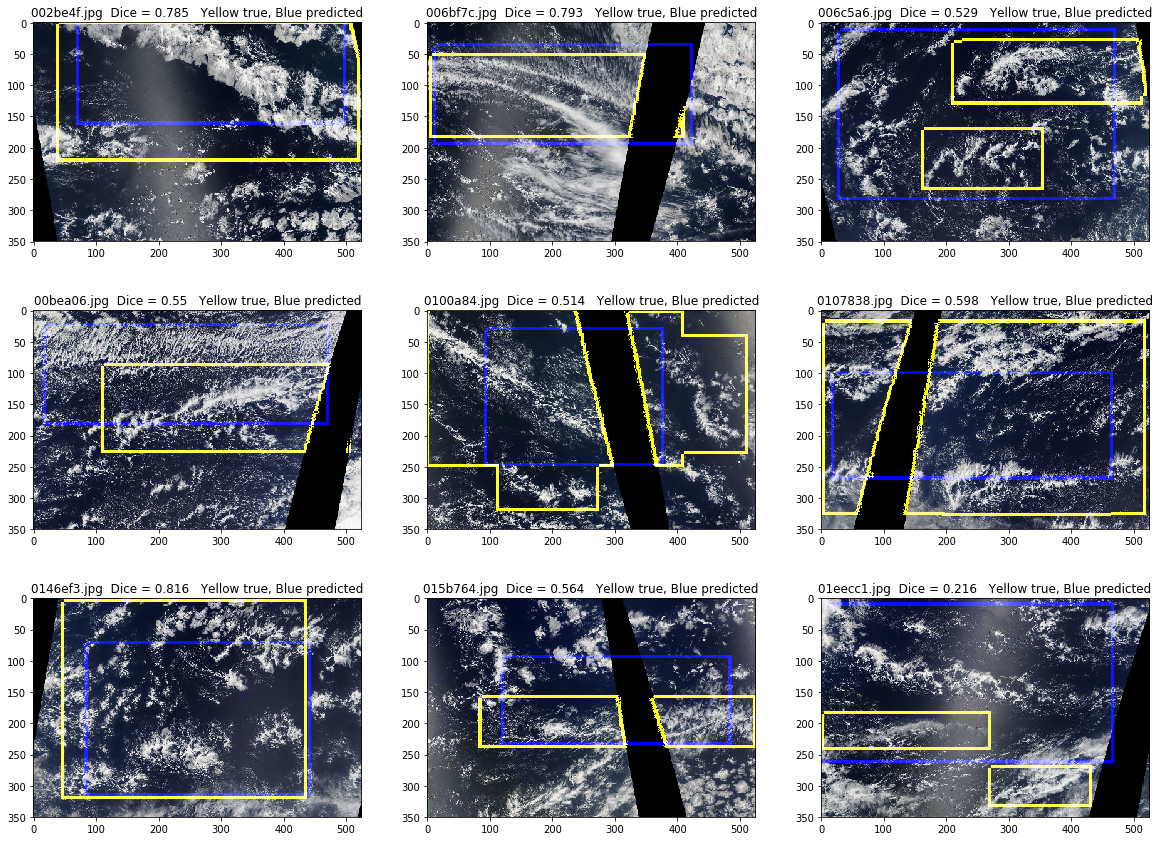

###########################
##### FLOWER CLOUDS #######
###########################


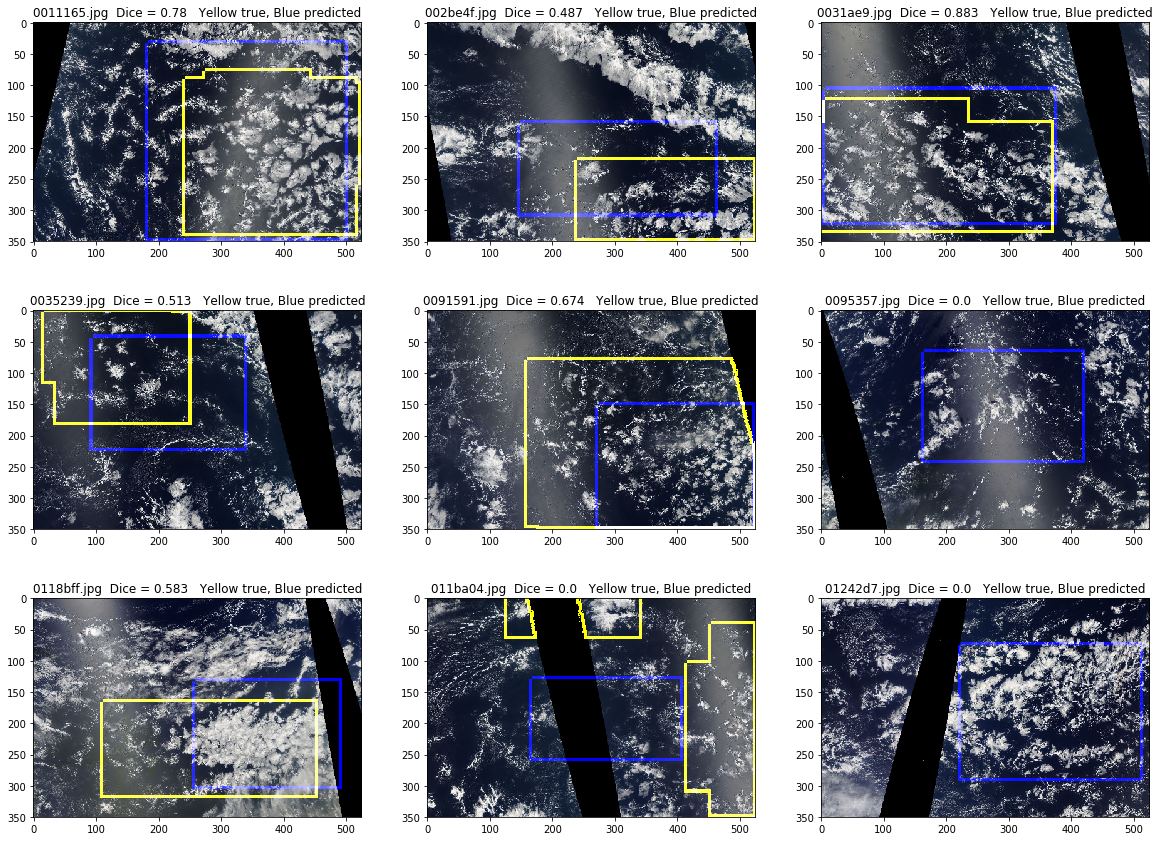

###########################
##### GRAVEL CLOUDS #######
###########################


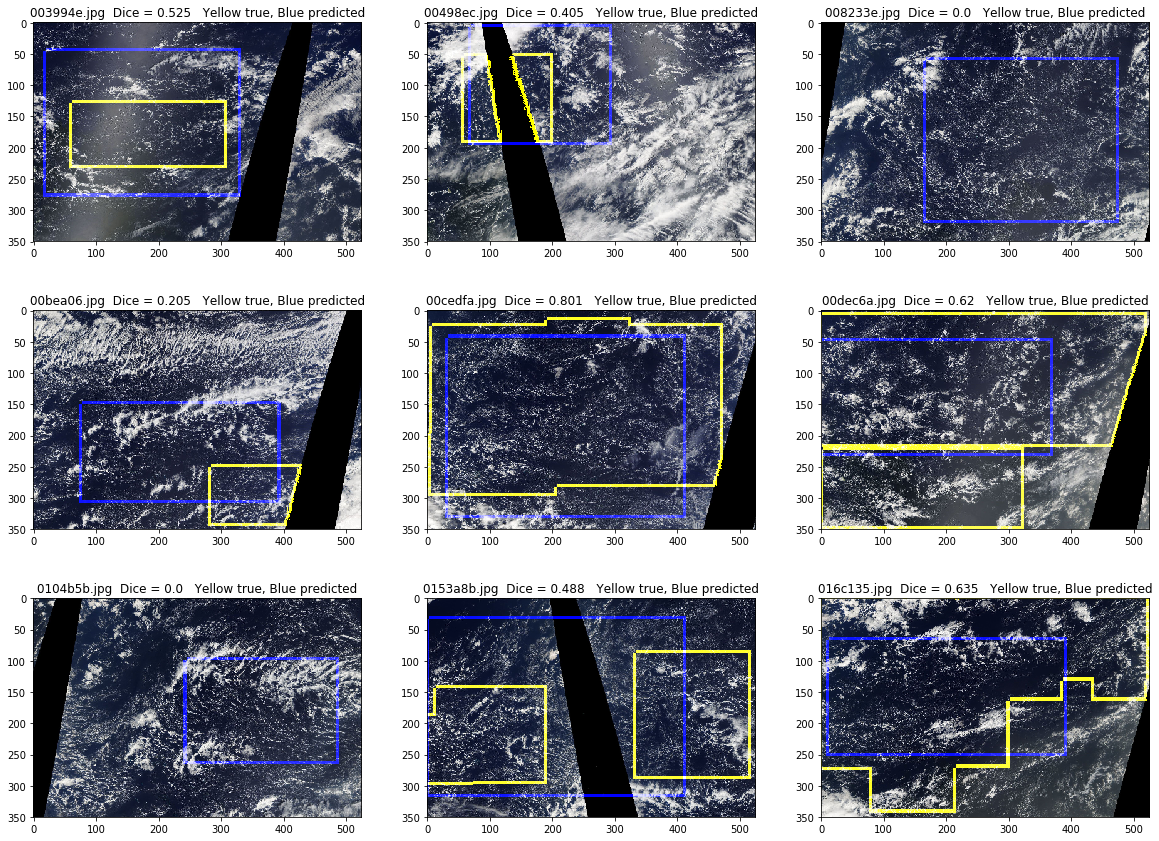

###########################
##### SUGAR CLOUDS #######
###########################


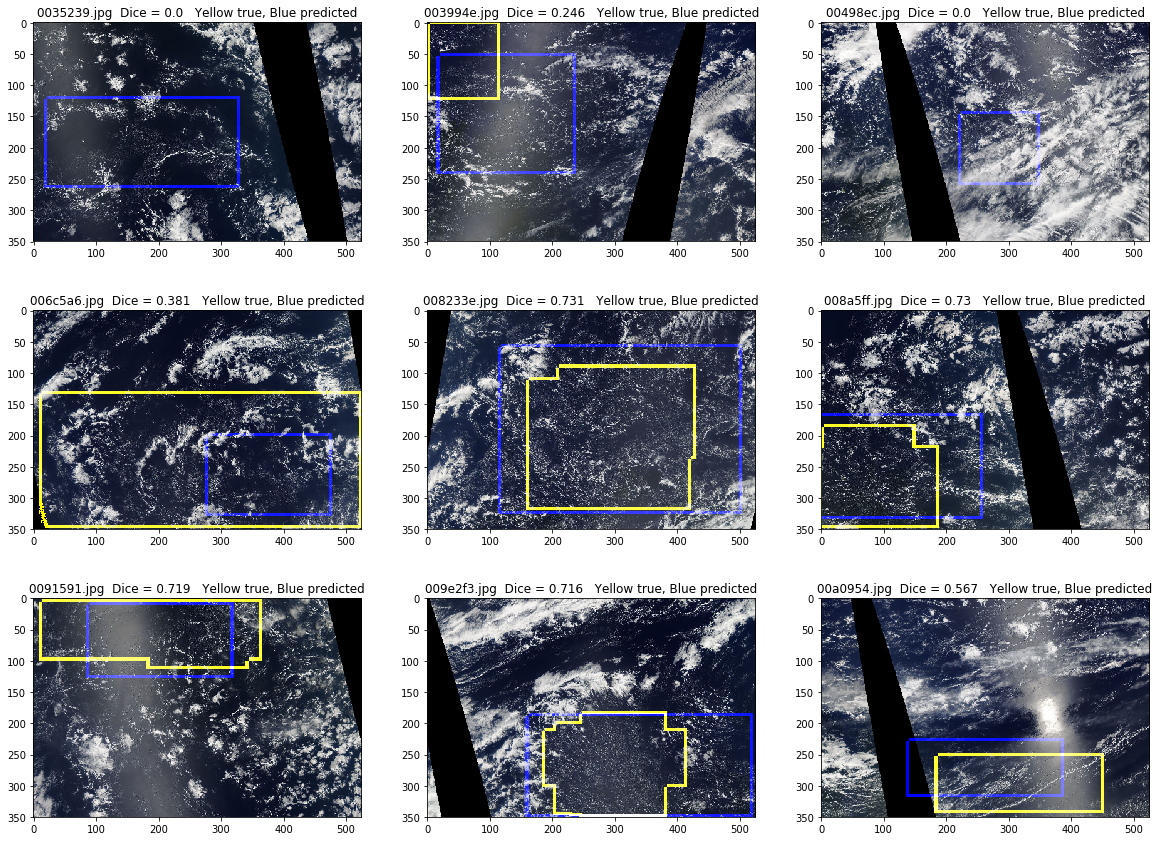

In [15]:
PATH = '../input/understanding_cloud_organization/train_images/'
for d in range(1,5):
    print('#'*27); print('#'*5,type2[d-1],'CLOUDS','#'*7); print('#'*27)
    plt.figure(figsize=(20,15)); k=0
    for kk in range(9):
        plt.subplot(3,3,kk+1)
        while (train2.loc[train2.index[k],'o'+str(d)]<0.65): k += 1
        f = train2.index[k]+'.jpg'
        img = Image.open(PATH+f); img = img.resize((525,350)); img = np.array(img)
        rle1 = train2.loc[train2.index[k],'e'+str(d)]; mask = rle2mask(rle1,shrink=4)
        contour = mask2contour(mask,5); img[contour==1,:2] = 255
        rle2 = train2.loc[train2.index[k],'bb'+str(d)]; mask = rle2mask(rle2,shape=(525,350))
        contour = mask2contour(mask,5); img[contour==1,2] = 255
        dice = np.round( dice_coef6(rle1,1,rle2,0),3 )
        plt.title(f+'  Dice = '+str(dice)+'   Yellow true, Blue predicted')
        plt.imshow(img); k += 1
    plt.show()

# Submit to Kaggle
We will now create our submission for kaggle

In [16]:
sub['pr'] = preds.reshape((-1))
sub['EncodedPixels'] = ''
for j in range(4):
    rles = []
    print('Converting bb2rle',j,'..., ',end='')
    for k in range( preds_bb.shape[0] ):
        rle = bb2rle( (preds_bb[k,0,j],preds_bb[k,1,j],preds_bb[k,2,j],preds_bb[k,3,j]) )
        rles.append(rle)
    sub.iloc[j::4,1] = rles
print('Done')
sub.loc[sub.pr<0.65,'EncodedPixels'] = ''
sub[['Image_Label','EncodedPixels']].to_csv('submission.csv',index=False)
sub.head(25)

Converting bb2rle 0 ..., Converting bb2rle 1 ..., Converting bb2rle 2 ..., Converting bb2rle 3 ..., Done


Image_Label                                      EncodedPixels  \
0     002f507.jpg_Fish                                                      
1   002f507.jpg_Flower                                                      
2   002f507.jpg_Gravel  3501 312 3851 312 4201 312 4551 312 4901 312 5...   
3    002f507.jpg_Sugar                                                      
4     0035ae9.jpg_Fish                                                      
5   0035ae9.jpg_Flower                                                      
6   0035ae9.jpg_Gravel  9539 224 9889 224 10239 224 10589 224 10939 22...   
7    0035ae9.jpg_Sugar  19727 180 20077 180 20427 180 20777 180 21127 ...   
8     0038327.jpg_Fish                                                      
9   0038327.jpg_Flower                                                      
10  0038327.jpg_Gravel                                                      
11   0038327.jpg_Sugar  9639 162 9989 162 10339 162 10689 162 11039 16...   
12    004f759.jpg_Fish                                                      
13  004f759.jpg_Flower  96987 258 97337 258 97687 258 98037 258 98387 ...   
14  004f759.jpg_Gravel                                                      
15   004f759.jpg_Sugar  5606 191 5956 191 6306 191 6656 191 7006 191 7...   
16    005ba08.jpg_Fish                                                      
17  005ba08.jpg_Flower                                                      
18  005ba08.jpg_Gravel  64051 251 64401 251 64751 251 65101 251 65451 ...   
19   005ba08.jpg_Sugar                                                      
20    006440a.jpg_Fish                                                      
21  006440a.jpg_Flower                                                      
22  006440a.jpg_Gravel                                                      
23   006440a.jpg_Sugar  51197 225 51547 225 51897 225 52247 225 52597 ...   
24    006f61b.jpg_Fish                                                      

      Image        pr  
0   002f507  0.270864  
1   002f507  0.023667  
2   002f507  0.996865  
3   002f507  0.548167  
4   0035ae9  0.512529  
5   0035ae9  0.164181  
6   0035ae9  0.776096  
7   0035ae9  0.739095  
8   0038327  0.339724  
9   0038327  0.525220  
10  0038327  0.467204  
11  0038327  0.919968  
12  004f759  0.518062  
13  004f759  0.833194  
14  004f759  0.361097  
15  004f759  0.671538  
16  005ba08  0.276520  
17  005ba08  0.044792  
18  005ba08  0.980006  
19  005ba08  0.562594  
20  006440a  0.441748  
21  006440a  0.206687  
22  006440a  0.606023  
23  006440a  0.919033  
24  006f61b  0.447789